In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D, Flatten
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#filtering warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
#path to data
path = ''

#Training Images
train_norm = os.listdir(path + "train/NORMAL")
train_covid = os.listdir(path + "train/PNEUMONIA")

#Testing Images
test_norm = os.listdir(path + "test/NORMAL")
test_covid = os.listdir(path + "test/PNEUMONIA")

In [6]:
def dataframe(filenames, classes):
    return pd.DataFrame({'Filename':filenames, 'Class':[classes]*len(filenames)})

#Forming Train and Test Dataframe
train_norm_df = dataframe(train_norm, 'Normal')
train_covid_df = dataframe(train_covid, 'Covid')

test_norm_df = dataframe(test_norm, 'Normal')
test_covid_df = dataframe(test_covid, 'Covid')

#Concating both classes into single datarame
train_df = pd.concat([train_norm_df, train_covid_df], axis=0)
test_df = pd.concat([test_norm_df, test_covid_df], axis=0)

In [7]:
#Path maker function
def pathmaker(df_name, df, empty_list):
    for i in df_name.values:
        if i[1] == 'Normal':
            empty_list.append(str(path + df + '/NORMAL/'+i[0]))
        else:
            empty_list.append(str(path + df + '/PNEUMONIA/'+i[0]))


#Empty list to be passed in path maker
train_path = []
test_path = []

#Assigning Path maker
pathmaker(train_df, 'train', train_path)
pathmaker(test_df, 'test', test_path)

train_df['Path'] = train_path
test_df['Path'] = test_path

#Shuffling / Re-arranging rows
train_df = train_df.sample(frac=1).reset_index(drop=True).iloc[:, 1:]
test_df = test_df.sample(frac=1).reset_index(drop=True).iloc[:, 1:]

train_df.head()

,Class,Path
0,Normal,train/NORMAL/IM-0085-0001.jpeg
1,Covid,train/PNEUMONIA/23E99E2E-447C-46E5-8EB2-D35D12...
2,Normal,train/NORMAL/IM-0019-0001.jpeg
3,Covid,train/PNEUMONIA/7AF6C1AF-D249-4BD2-8C26-449304...
4,Covid,train/PNEUMONIA/E63574A7-4188-4C8D-8D17-9D67A1...


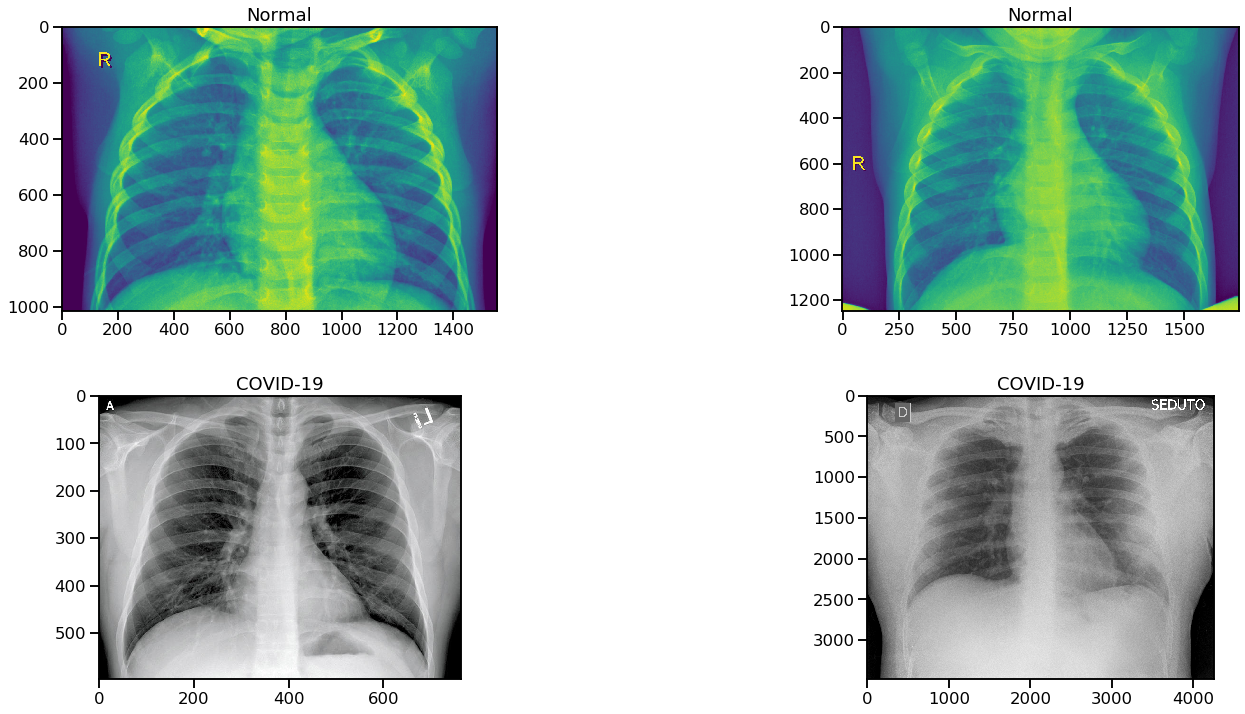

In [8]:
# Plotting Normal VS Covid in Grid

sns.set_context('talk')
plt.figure(figsize=(25,12))
plt.subplots_adjust(hspace=0.3)

plt.subplot(2, 2, 1)
plt.imshow(mpimg.imread(train_df[train_df['Class'] == 'Normal']['Path'].values[0]))
plt.title('Normal')

plt.subplot(2, 2, 2)
plt.imshow(mpimg.imread(train_df[train_df['Class'] == 'Normal']['Path'].values[6]))
plt.title('Normal')

plt.subplot(2, 2, 3)
plt.imshow(mpimg.imread(train_df[train_df['Class'] == 'Covid']['Path'].values[28]))
plt.title('COVID-19')

plt.subplot(2, 2, 4)
plt.imshow(mpimg.imread(train_df[train_df['Class'] == 'Covid']['Path'].values[26]))
plt.title('COVID-19')
plt.show()

In [9]:

def img_to_mtx(data, empty_array):
    for i in data:
        temp_img = image.load_img(i, target_size=(150,150))
        temp_img = img_to_array(temp_img)
        empty_array.append(temp_img)

#empty list
train_img = []
test_img = []

#Applying Image to Matrix
img_to_mtx(train_df['Path'], train_img)
img_to_mtx(test_df['Path'], test_img)

#keras preprocessing
train_img = preprocess_input(np.array(train_img))
test_img = preprocess_input(np.array(test_img))

In [10]:
#String to Numeric Label
train_df['Class'] = train_df['Class'].replace(['Covid','Normal'], [1,0])
test_df['Class'] = test_df['Class'].replace(['Covid','Normal'], [1,0])

#defining output layer's output
ytrain = to_categorical(train_df['Class'], num_classes=2)

In [11]:
#Saving best model while monitoring accuracy
model_chkpt = ModelCheckpoint('best_mod.h5', save_best_only=True, monitor='accuracy')

#early stopping for preventing overfitting
early_stopping = EarlyStopping(monitor='loss', restore_best_weights=False, patience=10)

In [16]:
model=Sequential()
    
#Normalization & Input
model.add(BatchNormalization(input_shape=(150, 150, 3)))

#CNN
model.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='relu'))

#Max Pooling
model.add(MaxPool2D(pool_size=(2,2)))

#Dropout
model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
#model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='relu'))


#Flattening I/P
model.add(Flatten())

#Dense layer
model.add(Dense(128, activation='relu'))

#Dropout
model.add(Dropout(0.1))

#Output Layer with sigmoid
model.add(Dense(2, activation='sigmoid'))

#Adam as optimizer, Accuracy as evaluation metrics
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [17]:
#overview of deep neural network
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 150, 150, 3)       12        
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 75, 75, 16)        4624      
_________________________________________________________________
flatten_1 (Flatten)          (None, 90000)            

In [18]:
#Model fitting and tracking historical accuracy / error score
history = model.fit(train_img, ytrain, 
          validation_split=0.10, 
          epochs=20, batch_size=32, shuffle=True, 
          callbacks=[model_chkpt, early_stopping]
         )

Train on 133 samples, validate on 15 samples
Epoch 1/20
133/133 [==============================] - 2s 12ms/sample - loss: 2.5472 - accuracy: 0.6241 - val_loss: 1.5125 - val_accuracy: 0.7000
Epoch 2/20
133/133 [==============================] - 0s 2ms/sample - loss: 0.4137 - accuracy: 0.8421 - val_loss: 0.2519 - val_accuracy: 0.9000
Epoch 3/20
133/133 [==============================] - 0s 2ms/sample - loss: 0.1724 - accuracy: 0.9436 - val_loss: 0.5231 - val_accuracy: 0.8667
Epoch 4/20
133/133 [==============================] - 0s 2ms/sample - loss: 0.0957 - accuracy: 0.9812 - val_loss: 0.3761 - val_accuracy: 0.9000
Epoch 5/20
133/133 [==============================] - 0s 2ms/sample - loss: 0.0652 - accuracy: 0.9812 - val_loss: 0.9737 - val_accuracy: 0.8667
Epoch 6/20
133/133 [==============================] - 0s 2ms/sample - loss: 0.0436 - accuracy: 0.9737 - val_loss: 0.4114 - val_accuracy: 0.8667
Epoch 7/20
133/133 [==============================] - 0s 2ms/sample - loss: 0.0426 - accur

Text(0, 0.5, 'Error')

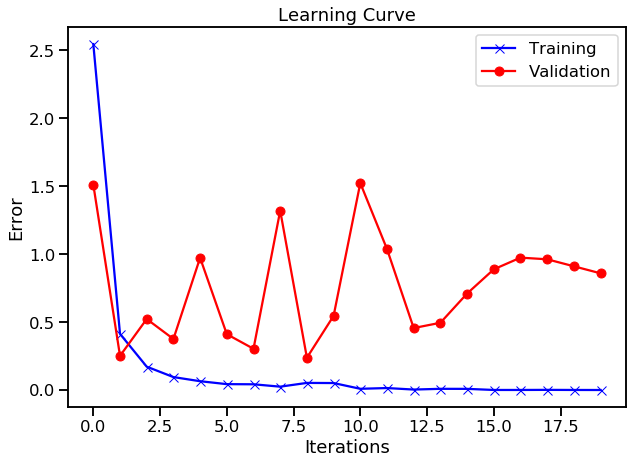

In [19]:
#plotting Learning curve over No. of Iterations
sns.set_context('talk')
plt.figure(figsize=(10,7))
plt.plot(history.history['loss'], 'b', label='Training', marker='x')
plt.plot(history.history['val_loss'], 'r', label='Validation', marker='o')
plt.legend()
plt.title('Learning Curve')
plt.xlabel('Iterations')
plt.ylabel('Error')

In [21]:
#prediction on test set
pred = model.predict(test_img, batch_size=32)
#pred

#converting Probabilities to labels
label = np.argmax(pred, axis=1)
#label

In [22]:
#Accuracy Score
print ('Accuracy Score : ', accuracy_score(label, test_df['Class'].values), '\n')

#precision, recall report
print ('Classification Report :\n\n' ,classification_report(label, test_df['Class'].values))

Accuracy Score :  1.0 

Classification Report :

               precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



Text(0.5, 1, 'Confusion Matrix')

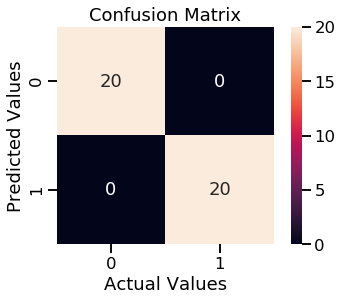

In [24]:
#plotting confusion matrix
sns.heatmap(confusion_matrix(label, test_df['Class'].values), annot=True, square=True)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix')